<a href="https://colab.research.google.com/github/JieJerryLiu/JieJerryLiu.github.io/blob/main/Recommendation_System_Movie_Jie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spark Moive Recommendation**
In this notebook, I use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

# Set Up Environments

## Spark

- https://medium.com/grabngoinfo/install-pyspark-3-on-google-colab-the-easy-way-577ec4a2bcd8

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
!pip install -q findspark
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark
from pyspark.sql.functions import col

## Libraries 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline 
#magic function

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [ ]:
ls

drive/  sample_data/  spark-3.2.1-bin-hadoop3.2/  spark-3.2.1-bin-hadoop3.2.tgz


In [ ]:
movies_df = spark.read.load("drive/MyDrive/LAIOFFER_FINAL_PROJECTS/RecSys_Movie/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/LAIOFFER_FINAL_PROJECTS/RecSys_Movie/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/LAIOFFER_FINAL_PROJECTS/RecSys_Movie/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/LAIOFFER_FINAL_PROJECTS/RecSys_Movie/tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


# Part 1: Spark SQL and OLAP

In [ ]:
movies_df.createOrReplaceTempView("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


### 1: The number of Users

In [ ]:
number_users_df = ratings_df.select('userID').distinct().count()

print("Total number of users is ", number_users_df, ".")

Total number of users is  610 .


In [ ]:
number_users_sql = spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
number_users_sql.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



In [ ]:
number_users_sql.toPandas()
print("Total number of user is {}".format(number_users_sql.toPandas().iloc[0,0]))

Total number of user is 610


### 2: The number of Movies

In [ ]:
number_movies_sql = spark.sql("Select Count(movieId) as Number_of_Moives from movies")
number_movies_sql.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



In [ ]:
number_movie_df = movies_df.select("movieID").distinct().count()

print("Total number of moives is ", number_movie_df, ".")

Total number of moives is  9742 .


### 3:  The number of movies are rated by users and movies that are not rated before

In [ ]:
# number of movies rated
rating_movies_sql = spark.sql("Select Count(movieId) as Number_of_Rated_Moives From movies Where movieID in (Select movieId From ratings)")
rating_movies_sql.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [ ]:
rating_movies_df = ratings_df.select("movieID").distinct().count()

print("Total number of movies rated by users is {}.".format(rating_movies_df))

Total number of movies rated by users is 9724.


In [ ]:
# movies that have not been rated before: 50 movies as an example
unrated_list=spark.sql('SELECT * ' +\
                       'FROM movies ' +\
                       'WHERE movieId NOT IN ( ' +\
                        'SELECT movieId ' +\
                        'FROM ratings ' +\
                       ') ' +\
                       'LIMIT 50')
print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

### 4: Movie Genres

In [ ]:
genres_list=spark.sql('select genres from movies').toPandas()
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [ ]:
genres_list_sql = spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
genres_list_sql.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [ ]:
# size of each category 
numMovies_category_sql = spark.sql("Select genres,Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By 1 Order by 2 DESC")
numMovies_category_sql.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [ ]:
# list all movie for each category 
name_movie_category_sql = spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By 1")
name_movie_category_sql.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

# Part2: Spark ALS based approach for training model

## Datasets

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movie_ratings=ratings_df.drop('timestamp')

In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [ ]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



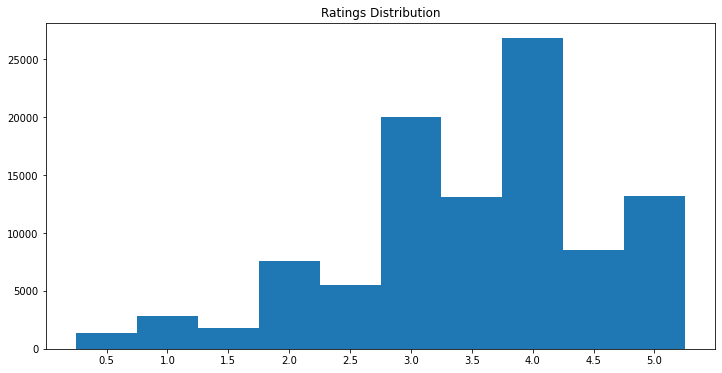

In [ ]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## ALS Model Selection and Evaluation


In [ ]:
# Import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
#Create test and train set
(training,test) = movie_ratings.randomSplit([0.8,0.2])

In [ ]:
#Create ALS model
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6) 

In [ ]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation 
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [ ]:
print(cvModel.avgMetrics)

[0.9240288384553914, 0.9240288384553907, 0.9240288384553912, 0.9300152171253373, 0.9300152171253373, 0.930015217125338, 0.9361281866093304, 0.9361281866093312, 0.9361281866093316, 0.9294629465884683, 0.9294629465884678, 0.929462946588468, 0.9242614630366679, 0.924261463036667, 0.9242614630366663, 1.096780268459558, 1.096780268459559, 1.0967802684595587, 1.1855837751128893, 1.1855837751128881, 1.1855837751128884, 1.2555394333491097, 1.2555394333491097, 1.2555394333491092, 1.3354035293058082, 1.3354035293058073, 1.3354035293058086, 1.391769873045948, 1.391769873045948, 1.3917698730459485, 1.4849789370146866, 1.484978937014687, 1.4849789370146862, 1.5130402305764505, 1.5130402305764497, 1.5130402305764503, 1.6417335687931858, 1.6417335687931875, 1.6417335687931893, 1.8352683017855131, 1.8352683017855123, 1.8352683017855123, 1.8864782263188422, 1.8864782263188442, 1.8864782263188427, 0.9100245838662573, 0.910024583866256, 0.9100245838662571, 0.91079707538748, 0.9107970753874804, 0.91079707

In [ ]:
print(np.argmin(cvModel.avgMetrics))
# min ALS

102


In [ ]:
print(cvModel.getEstimatorParamMaps())

[{Param(parent='ALS_032f84a4e781', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='ALS_032f84a4e781', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_032f84a4e781', name='rank', doc='rank of the factorization'): 5, Param(parent='ALS_032f84a4e781', name='alpha', doc='alpha for implicit preference'): 0.1}, {Param(parent='ALS_032f84a4e781', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='ALS_032f84a4e781', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_032f84a4e781', name='rank', doc='rank of the factorization'): 5, Param(parent='ALS_032f84a4e781', name='alpha', doc='alpha for implicit preference'): 0.01}, {Param(parent='ALS_032f84a4e781', name='maxIter', doc='max number of iterations (>= 0).'): 3, Param(parent='ALS_032f84a4e781', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_032f84a4e781', name='rank', doc='rank of the factorization'): 

In [ ]:
# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 25
-> alpha: 0.1


In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.4837824991910567


## Model testing
Make a prediction and check the testing error.

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)

In [ ]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())), 
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))

RMSE = 0.879577928894575
**Best Model**
 Rank:  25
 MaxIter:  10
 RegParam:  0.1


In [ ]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   580|   1580|   4.0| 3.6558356|
|    34|   1580|   2.5| 3.3416553|
|   368|   1645|   3.0| 3.1875582|
|   385|    471|   4.0| 3.4575915|
|   183|   1580|   4.0| 3.8411965|
|   332|   1645|   3.5|  3.129385|
|   577|   1959|   4.0| 3.3926704|
|    44|    833|   2.0| 2.5613637|
|   606|   1088|   3.0| 3.2879496|
|   606|   1959|   3.5| 3.4933593|
|   602|    471|   4.0| 3.2300053|
|    91|    471|   1.0| 3.0082564|
|    91|   3175|   3.5| 3.0701923|
|   409|    471|   3.0| 3.3932104|
|   157|   3175|   2.0|  3.419495|
|   232|  68135|   4.0| 3.2277513|
|   346|   8638|   4.0|  3.270881|
|   599|   1342|   2.5| 2.4534192|
|   599|   1580|   3.0| 2.9347553|
|   599|   1591|   2.5| 2.1216812|
+------+-------+------+----------+
only showing top 20 rows



## Model apply and see the performance

In [ ]:
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.581888203810293


In [ ]:
alldata.createOrReplaceTempView("alldata")

In [ ]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.4053252|
|   137|   1580|   3.5| 3.3819265|
|   580|   1580|   4.0| 3.6558356|
|   580|   3175|   2.5| 3.2645736|
|   580|  44022|   3.5| 3.4524035|
|   133|    471|   4.0|  3.296358|
|   322|   1580|   3.5| 3.4365146|
|   362|   1591|   4.0| 3.3133686|
|   362|   1645|   5.0|  3.765933|
|   593|   1580|   1.5| 2.6630096|
|   597|    471|   2.0| 3.1928482|
|   597|   1580|   3.0|  3.414426|
|   597|   1959|   4.0| 3.9858823|
|   597|   2366|   5.0|   4.52139|
|   108|   1959|   5.0|  4.651726|
|   155|   1580|   4.0|  4.029435|
|   155|   3175|   4.0| 3.7906594|
|    34|   1580|   2.5| 3.3416553|
|    34|   3997|   2.0| 1.8552606|
|   368|   1580|   3.0|  3.081088|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5| 3.4053252|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5| 3.3819265|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0| 3.6558356|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5| 3.2645736|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5| 3.4524035|
|    471|Hudsucker Proxy, ...|              Comedy|   133|    471|   4.0|  3.296358|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   322|   1580|   3.5| 3.4365146|
|   1591|        Spawn (1997)|Action|Adventure|...|   362|   1591|   4.0| 3.3133686|
|   1645|The Devil's Advoc...|Drama|Mystery|Thr...|   362|   1645

## Recommend moive to users with id: 575, 232. 
you can choose some users to recommend the moives 

In [ ]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out



# top 10 for user 575
topKRecommend(10,575,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,movieId,title,genres,predicted_ratings
1,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,4.884698
2,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,4.775285
3,430,Calendar Girl (1993),Comedy|Drama,4.773774
4,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.772408
5,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.709968
6,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.705808
7,51931,Reign Over Me (2007),Drama,4.689488
8,110,Braveheart (1995),Action|Drama|War,4.623497
9,778,Trainspotting (1996),Comedy|Crime|Drama,4.617350
10,1246,Dead Poets Society (1989),Drama,4.609714


In [ ]:
# top 15 for user 232
topKRecommend(15,232,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,movieId,title,genres,predicted_ratings
1,173963,Empties (2007),Comedy,4.409193
2,163072,Winnie Pooh (1969),Animation|Children,4.409193
3,179133,Loving Vincent (2017),Animation|Crime|Drama,4.409193
4,175431,Bobik Visiting Barbos (1977),Animation|Comedy,4.409193
5,163112,Winnie the Pooh Goes Visiting (1971),Animation,4.409193
6,172793,Vovka in the Kingdom of Far Far Away (1965),Adventure|Animation|Children|Fantasy,4.409193
7,175293,Gena the Crocodile (1969),Animation|Children,4.409193
8,147300,Adventures Of Sherlock Holmes And Dr. Watson: ...,Crime|Mystery,4.409193
9,130970,George Carlin: Life Is Worth Losing (2005),Comedy,4.409193
10,147330,Sherlock Holmes and Dr. Watson: Acquaintance (...,Crime,4.409193


In [ ]:
# access the movie factor matrix
movie_factors=bestModel.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
# generate a comd combining movieId and feature 0 -15, and then split, 
# You can execute Spark column functions with a genius combination of expr and eval().
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+-------------+-----------+----------+-----------+-----------+-------------+----------+-----------+------------+------------+----------+------------+------------+------------+------------+------------+------------+-------------+-----------+-------------+------------+------------+------------+------------+----------+
|movieId|     feature0|   feature1|  feature2|   feature3|   feature4|     feature5|  feature6|   feature7|    feature8|    feature9| feature10|   feature11|   feature12|   feature13|   feature14|   feature15|   feature16|    feature17|  feature18|    feature19|   feature20|   feature21|   feature22|   feature23| feature24|
+-------+-------------+-----------+----------+-----------+-----------+-------------+----------+-----------+------------+------------+----------+------------+------------+------------+------------+------------+----------

In [ ]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(bestModel.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))  
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [ ]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(bestModel.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<bestModel.rank-1:      
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))  
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [ ]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

,movieId,title,genres
1,438,"Cowboy Way, The (1994)",Action|Comedy|Drama
2,340,"War, The (1994)",Adventure|Drama|War
3,709,Oliver & Company (1988),Adventure|Animation|Children|Comedy|Musical
4,2124,"Addams Family, The (1991)",Children|Comedy|Fantasy
5,3837,Phantasm II (1988),Action|Fantasy|Horror|Sci-Fi|Thriller
6,212,Bushwhacked (1995),Adventure|Comedy|Crime|Mystery
7,280,Murder in the First (1995),Drama|Thriller
8,304,Roommates (1995),Comedy|Drama
9,339,While You Were Sleeping (1995),Comedy|Romance
10,210,Wild Bill (1995),Western


In [ ]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

,movieId,title,genres
1,3889,Highlander: Endgame (Highlander IV) (2000),Action|Adventure|Fantasy
2,706,Sunset Park (1996),Drama
3,1167,Dear God (1996),Comedy
4,8864,Mr. 3000 (2004),Comedy|Drama
5,3087,Scrooged (1988),Comedy|Fantasy|Romance
6,2641,Superman II (1980),Action|Sci-Fi
7,4743,Tortilla Soup (2001),Comedy|Romance
8,2687,Tarzan (1999),Adventure|Animation|Children|Drama
9,5792,Roger Dodger (2002),Comedy|Drama
10,5443,Juwanna Mann (2002),Comedy


In [ ]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

,movieId,title,genres
1,1552,Con Air (1997),Action|Adventure|Thriller
2,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
3,3256,Patriot Games (1992),Action|Crime|Drama|Thriller
4,1441,Benny & Joon (1993),Comedy|Romance
5,2097,Something Wicked This Way Comes (1983),Children|Drama|Fantasy|Mystery|Thriller


In [ ]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

,movieId,title,genres
1,85354,Mesrine: Public Enemy #1 (L'ennemi public n°1)...,Action|Crime
2,2687,Tarzan (1999),Adventure|Animation|Children|Drama
3,511,"Program, The (1993)",Action|Drama
4,2563,Dangerous Beauty (1998),Drama
5,706,Sunset Park (1996),Drama
